# tvQAR(1)
###### Author: Mokhtar Z. Alaya <alayaelm@utc.fr>
###### Ref: J. R. Statist. Soc. B (2017) 79, Part 5, pp. 1619–1643, " Quantile spectral analysis for locally stationary time series"


\begin{equation*}
X_{t,T} = 
\end{equation*}


In [3]:

import warnings
warnings.filterwarnings('ignore')

import torch

import numpy as np
import scipy as scp

import matplotlib
from matplotlib import cm
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
%matplotlib inline
#from matplotlib import rc
#rc('font', **{'family': 'sans-serif', 'sans-serif': ['Computer Modern Roman']})
params = {'axes.labelsize': 8, # 12
          'font.size': 8, # 12
          'legend.fontsize': 8, # 12
          'xtick.labelsize': 8, # 10
          'ytick.labelsize': 8, # 10
          'text.usetex': True,
          'figure.figsize': (10, 8)}
plt.rcParams.update(params)

import seaborn as sns

from src.utils import *
from src.kernels import Kernel

from scipy.stats import wasserstein_distance

# Plot process

In [4]:
T = 1000
n_replications = 1
d = 2


phi_star = lambda u, U: (1.9*U - 0.95)*u + (-1.9*U + 0.95) *(1-u) * U
psi_star = lambda  u: 1.0 
sigma_star = lambda u: 1.0
m_star = lambda u, U, x: phi_star(u, U) * x

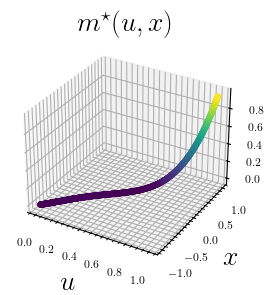

In [9]:
# Plot of m^star
# plt.rcParams["figure.figsize"] = (24,3)

u = np.linspace(0., 1., T)
U = np.linspace(0, 1., T)
x = np.linspace(-1., 1., T)
u_mesh, x_mesh = np.meshgrid(u, x)

m_star_vals_mesh = m_star(u_mesh, U, x_mesh)
m_star_vals = m_star(u, U, x)
# ax = plt.axes(projection='3d')
# ax.plot3D(u, x, m_star_vals, 'gray')
# plt.show()
fig = plt.figure()
ax = plt.axes(projection='3d')
plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
plt.minorticks_on()
# ax.contour3D(u_mesh, y_mesh, m_star_vals_mesh, 50, cmap='binary')
ax.scatter(u, x, m_star_vals, c=m_star_vals, cmap='viridis', linewidth=0.1);
ax.set_xlabel(r'$u$', fontsize=20)
ax.set_ylabel(r'$x$', fontsize=20)
ax.set_title(r'$m^\star(u,x)$', fontsize=20)
plt.savefig("m_star_tvQR_1.pdf", dpi=300)
plt.tight_layout()
plt.show()

In [6]:

T = 1000
n_replications = 1
d = 2

np.random.seed(42)
X_tvar_2 = np.zeros(T)
X_tvar_2_mean = np.zeros(T)

X_tvar_2_replications = np.zeros((n_replications, T))

X_dict = {}

for replication in range(n_replications):
    t = 1
    epsilon = np.random.uniform(size=T)
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvar_2[t] = m_star(t/T, epsilon[t], X_tvar_2[t-1]) + sigma_star(t/T) * epsilon[t] - 0.5
        X[t] = [X_tvar_2[t-1]]
        t += 1
        
    X_dict[str(replication)] = X
    X_tvar_2_replications[replication] = X_tvar_2

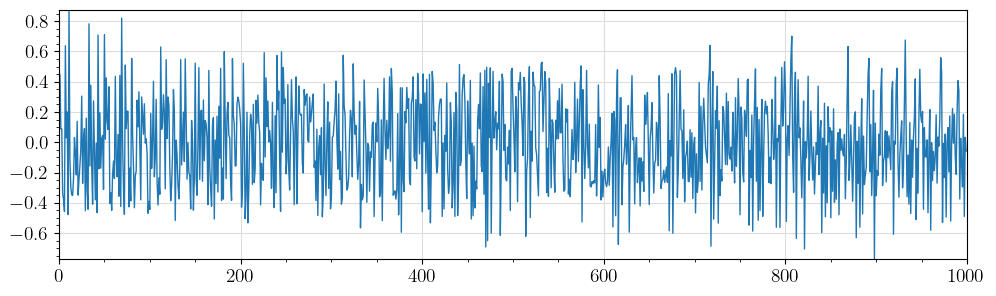

In [8]:
path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.grid(which='major', color='#DDDDDD', linewidth=0.8)
    plt.minorticks_on()
    plt.plot(X_tvar_2_replications[replication], lw=1)
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    plt.ylim(min(X_tvar_2_replications[replication]) , max(X_tvar_2_replications[replication]))
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    # plt.legend()
    plt.tight_layout()
    plt.savefig(path_fig+"tv_QAR_1.pdf", dpi=300)

## NW estimator for the conditional mean function

Note that NW estimator of $m^\star(u,\boldsymbol{x})$ is given by  $\hat m(u,\boldsymbol{x}) 
% = \E_{\hat{\pi}_t(\cdot|\boldsymbol{x})}[Y_{t,T}| \boldsymbol{X}_{t,T}=\boldsymbol{x}]
= \sum_{a=1}^T   \omega_{a}(u, \boldsymbol{x}) Y_{a,T}$.

In [6]:
space_kernel = "gaussian" # "silverman"
time_kernel = "uniform"
bandwidth = T **(-0.4 / (d+1))
Y_t_T = X_tvar_2_replications[0]

GaussUnifKernel = Kernel(T=T, bandwidth=bandwidth, space_kernel=space_kernel, time_kernel=time_kernel)
GaussUnifKernel 

Kernel(T=1000, bandwidth=0.39810717055349726, time_kernel='uniform')

In [ ]:
weights = {}
for t in range(T):
    weights[str(t)] = GaussUnifKernel.fit(X_dict['0'], t)

In [ ]:
weights['0'].shape, Y_t_T.shape

In [ ]:
m_hat= [np.sum(weights[str(t)] * Y_t_T) for t in range(T)]
# for t in range(T): m_hat.append(np.sum(weights[str(t)] * Y_t_T))

In [ ]:
path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=1, label="LSP")
    plt.plot(np.array(m_hat), lw=1, label="Condional mean function")
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_fig+"locally_process_conditional_mean_Guassina_space_kernel_uniform_tiem_kernel.pdf", dpi=150)

In [ ]:
path_fig = "/Users/mzalaya/Library/CloudStorage/Dropbox/research/git/wasslsp/figs/"
plt.rcParams["figure.figsize"] = (10,3)

u_var = np.linspace(0., 1., T)

for replication in range(n_replications):
    plt.plot(X_tvar_2_replications[replication], lw=1, label="LSP")
    plt.plot(np.array(m_hat), lw=1, label="Condional mean function")
    # plt.plot(X_tvar_2_replications_u_var[replication], lw=2)
    # plt.plot(X_tvar_2_mean)
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, T)
    # plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_fig+"locally_process_conditional_mean", dpi=150)

## Approximate process

In [21]:
T = 1000
n_replications = 1
d = 2

u_var = np.linspace(0., 1., T)

X_tvar_2_u_var= np.zeros(T)

X_tvar_2_replications_u_var = np.zeros((n_replications, T))


for replication in range(n_replications):
    t = 2
    epsilon = np.random.normal(size=(T))
    X = np.zeros((T,d))
    while t <= T-1 :
        X_tvar_2_u_var[t] = m_star(t/T, X_tvar_2[t-1], X_tvar_2[t-2]) + sigma_star(t/T) * epsilon[t]
        
        # 2 / r_star(u_var[t]) * np.cos(m_star(u_var[t])) * X_tvar_2[t-1] - \
                       # 1. / (r_star(u_var[t])) ** 2 * X_tvar_2[t-2] + sigma_star(u_var[t]) * epsilon[t]
        t += 1

    X_tvar_2_replications_u_var[replication] = X_tvar_2_u_var

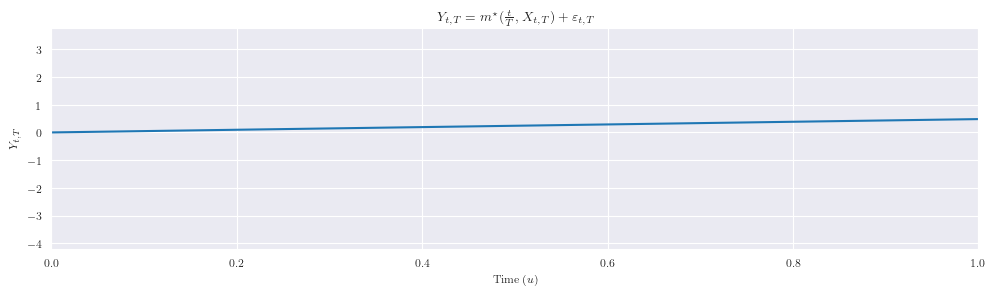

In [22]:
for replication in range(n_replications):
    # plt.plot(u_var, X_tvar_2_replications_u_var[replication], lw=2)
    plt.plot(X_tvar_2_replications[replication] - X_tvar_2_replications_u_var[replication])
    # plt.plot(X_tvar_2_mean)
    plt.xlabel(r'$\textrm{Time}\, (u)$')
    plt.ylabel(r'$Y_{t,T}$')
    # plt.xticks(np.arange(0, T+1, 200, dtype=int))
    plt.xlim(0, 1)
    plt.title(r'$Y_{t,T} = m^\star(\frac{t}{T}, X_{t,T}) + \varepsilon_{t,T}$')
    # plt.legend()
    plt.tight_layout()
    plt.savefig(path_fig+"exp_1_approx_locally_stat_Y", dpi=150)

In [23]:
## Dimensions

In [24]:
# times_T = [5000, 10000 , 15000, 20000, 25000, 30000, 35000, 40000, 50000, 100000]
times_T = [1000, 2000, 300, 400, 5000]
# times_t = [1000, 2000, 3000, 5000]# , 3000, 5000]
# times_t = [100, 200, 300, 400, 500, 600, 700, 800, 900]# 400, 500]# , 3000, 5000]

times_t = [200, 300, 400, 500, 600] 

d = 2
n_replications = 5

In [25]:
0.3 * np.array(times_T)

array([ 300.,  600.,   90.,  120., 1500.])

In [26]:
# np.array(times_t) / np.array(times_T)

In [27]:
times_T = [1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
xi = 0.499/ (d+1)
times_T * np.array(times_T)**(-xi) /20

array([ 15.84783732,  28.24416093,  39.6031828 ,  50.33700251,
        60.62866395,  70.5811554 ,  80.26016909,  89.71106729,
        98.96694776, 108.05296064])

In [28]:
np.array(times_T)**(-xi) /10 * times_T

array([ 31.69567463,  56.48832186,  79.20636559, 100.67400502,
       121.2573279 , 141.1623108 , 160.52033818, 179.42213458,
       197.93389551, 216.10592128])

0.0001
0.018607407407407406
0.037114814814814816
0.055622222222222226
0.07412962962962963
0.09263703703703703
0.11114444444444445
0.12965185185185182
0.14815925925925924
0.16666666666666666


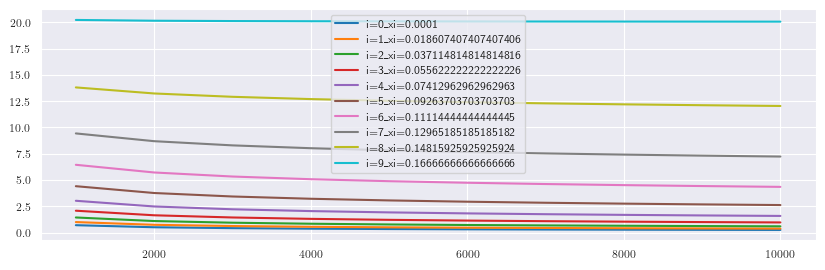

In [29]:
# xi = # < 1/(2*(d+1))
for i, xi in zip(range(10), np.linspace(1e-4, 1./(2*(d+1)), 10)):
    
    bandwidths = np.array(times_T)**(-xi) 

    bounds = 1./(np.sqrt(np.array(times_T)) * bandwidths**(d+1) / 20) + 1./(np.array(times_T) * bandwidths**(d)/20) + bandwidths/20
    plt.plot(times_T, bounds, label=f"i={i}_xi={xi}")
    print(xi)
    plt.legend()

In [30]:
0.0001 * 3

0.00030000000000000003

In [31]:
1000**(- 0.0001 * 3 / 3) /20,  1/1000

(0.049965473150129495, 0.001)

In [32]:
1 / (np.sqrt(1000) * 1000**(- 0.0001 * 3 / 3))

0.031644628388355245

In [33]:

X_tvar_2 = {}
X_tvar_2_replications = {}
X_dict = {}

# "T:"+str(T
for T in times_T:
    X_tvar_2_replications[f"T:{T}"] = np.zeros((n_replications, T))
    X_dict[f"T:{T}"] = {}

In [34]:
# X_dict

In [35]:
for T in times_T:
    u_var = np.linspace(0., 1., T)

    for replication in range(n_replications):
        t = 2
        epsilon = np.random.normal(size=(T))
        X = np.zeros((T,d))
        X_tvar_2_T = np.zeros(T)
        while t <= T-1 :
            X_tvar_2_T[t] = m_star(t/T, X_tvar_2_T[t-1], X_tvar_2_T[t-2]) + sigma_star(t/T) * epsilon[t]
            
            X[t] = [X_tvar_2_T[t-1], X_tvar_2_T[t-2]]
            t += 1

        X_tvar_2_replications[f"T:{T}"][replication] = X_tvar_2_T
        X_dict[f"T:{T}"][str(replication)] = X


In [36]:
# X_dict.keys() # dict_keys(['T:5000', 'T:10000'])
# X_tvar_2_replications.keys() # dict_keys(['T:5000', 'T:10000'])
# X_dict['T:5000'].keys() # 500 replications
# X_tvar_2_replications['T:5000'].shape # (500, 5000) : 500 replications of T-length LSP

In [37]:
# X_tvar_2_replications['T:5000'].shape

In [38]:
X_tvar_2 = {}

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = {}

# X_tvar_2

In [39]:
for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = []


for t in times_t:
    for replication in range(n_replications):
        for T in times_T:
            z = X_tvar_2_replications[f"T:{T}"][replication][t-1]
            X_tvar_2[f"t:{t}_T:{T}"].append(z)

for t in times_t:
    for T in times_T:
        X_tvar_2[f"t:{t}_T:{T}"] = np.array(X_tvar_2[f"t:{t}_T:{T}"])

In [40]:
# X_tvar_2.keys()

In [41]:
plt.rcParams["figure.figsize"] = (5,4)

norm_X_tvar_2 = {}
for t in times_t:
    for T in times_T:
        norm_X_tvar_2[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])

        # sns.lineplot(
            # x=X_tvar_2[f"t:{t}_T:{T}"], y=norm_X_tvar_2[f"t:{t}_T:{str(T)}"], lw=2, markers=True,
            # label=f"(t,T)={t, T}",  drawstyle='steps-mid',          
        # )
        # plt.legend()
        # plt.tight_layout()

# Nadara-Watson estimator: Gaussian kernel

In [42]:
## Gaussian 
# kernel = "gaussian"
kernel = "epanechnikov"
xi = 0.4 / (2*(d+1))

gaussian_kernel = {}
gaussian_weights = {}

for t in times_t:
    for T in times_T:
        gaussian_weights[f"t:{t}_T:{T}"] = {}
    
for T in times_T:
    bandwidth = T **(-xi) / 10
    gaussian_kernel[f"T:{T}"] = Kernel(T=T, bandwidth=bandwidth, space_kernel=kernel, time_kernel=kernel)

In [43]:
# gaussian_weights

In [44]:
gaussian_kernel

{'T:1000': Kernel(T=1000, bandwidth=0.06309573444801933, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:2000': Kernel(T=2000, bandwidth=0.06024643228025249, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:3000': Kernel(T=3000, bandwidth=0.058639723839460776, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:4000': Kernel(T=4000, bandwidth=0.05752580002835659, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:5000': Kernel(T=5000, bandwidth=0.05667636646017325, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:6000': Kernel(T=6000, bandwidth=0.055991647963734625, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:7000': Kernel(T=7000, bandwidth=0.055419184483192885, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:8000': Kernel(T=8000, bandwidth=0.05492802716530589, space_kernel='epanechnikov',
        time_kernel='epanechnikov'),
 'T:9000': Ke

In [45]:
for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            # print(X_dict[f"T:{T}"][str(replication)].shape, "\n")
            # print(gaussian_kernel[f"T:{T}"], "\n")
            # print(gaussian_weights[f"t:{t}_T:{T}"], "\n")
            gaussian_weights[f"t:{t}_T:{T}"][str(replication)] = \
            gaussian_kernel[f"T:{T}"].fit(X_dict[f"T:{T}"][str(replication)], t-1)

In [46]:
# gaussian_weights['t:1000_T:5000'].keys() # 500 replications
# gaussian_weights['t:1000_T:5000']['0'] # 500 weights
# gaussian_weights['t:1000_T:5000']['0'].sum() # 1
# gaussian_weights['t:1000_T:5000']['0'].shape

In [47]:
n_replications

5

In [48]:
gaussian_weights_tensor =  {} #= torch.empty((len(times_t), len(times_T), )

# torch.zeros((len(times_t), len(times_T), n_replications, None))
# gaussian_weights_tensor.size() # torch.Size([len(times_t), len(times_T), n_replications])

for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):
        gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"] = {}


for i_t in range(len(times_t)):
    for i_T in range(len(times_T)):  
        for replication in range(n_replications):
            gaussian_weights_tensor[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)] =\
            gaussian_weights[f"t:{times_t[i_t]}_T:{times_T[i_T]}"][str(replication)]

In [49]:
# gaussian_weights_tensor.keys()


In [50]:
# gaussian_weights_tensor['t:1000_T:5000']['0'].shape

\begin{align}
  \omega_{a}(\frac t T, \boldsymbol{x})=\frac{\displaystyle  K_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j- X_{a,T}^j)}{\displaystyle \sum_{a=1}^TK_{h,1}(\frac{t}{T} - \frac{a}{T})\prod_{j=1}^dK_{h,2}(x^j - X_{a,T}^j)}.
 \end{align}

In [51]:
# plt.rcParams["figure.figsize"] = (10,3)

# plt.plot(gaussian_weights_tensor['t:1000_T:5000']['0'], label="replication n° 1")
# plt.plot(gaussian_weights_tensor['t:1000_T:5000']['499'], label="replication n° 500")
# plt.xlabel(r'$\textrm{Time}\, (t)$')
# plt.ylabel(r'$\omega_a(\frac{t}{T}, x)$')
# plt.xlim(0, 5000)
# plt.title(r'weights $\omega_{a}(\frac{t}{T}, x)\quad (t=1000, T=5000)$')
# plt.legend()
# plt.tight_layout()
# plt.savefig(path_fig+"weights", dpi=150)


In [52]:
# gaussian_weights_tensor.keys()

In [53]:
# plt.rcParams["figure.figsize"] = (10,3)

# plt.plot(gaussian_weights_tensor['t:1000_T:10000']['0'], label="replication n° 1")
# plt.plot(gaussian_weights_tensor['t:1000_T:10000']['499'], label="replication n° 500")
# plt.xlabel(r'$\textrm{Time}\, (t)$')
# plt.ylabel(r'$\omega_a(\frac{t}{T}, x)$')
# plt.xlim(0, 5000)
# plt.title(r'weights $\omega_{a}(\frac{t}{T}, x)\quad (t=1000, T=10000)$')
# plt.legend()
# plt.tight_layout()
# plt.savefig(path_fig+"weights_", dpi=150)

The associated conditional CDF to $\hat{\pi}_t(\cdot|\boldsymbol{x})$ is defined as, for all $y \in \R,$  
\begin{equation}
  \hat{F}_{t}(y|\boldsymbol{x})=\sum_{a=1}^T\omega_{a}(\frac tT,\boldsymbol{x}) \mathbf{1}_{Y_{a,T}\leq y}. %, \quad \text{for all $y\in\R$}. %  \ind{}(Y_{a,T}\leq y) 
\end{equation}


In [54]:
# X_tvar_2_replications.keys() # dict_keys(['T:5000', 'T:10000'])
# X_tvar_2_replications['T:5000'].shape # (500, 5000)
# X_tvar_2[f"t:{t}_T:{T}"], norm_X_tvar_2[f"t:{t}_T:{str(T)}"]
# X_tvar_2.keys() # dict_keys(['t:1000_T:5000', 't:1000_T:10000', 't:2000_T:5000', 't:2000_T:10000'])

In [55]:
# X_tvar_2.keys()

In [56]:
# X_tvar_2['t:1000_T:5000'].shape, X_tvar_2_replications['T:5000'].shape

In [57]:
# X_tvar_2_replications['T:5000'][0].shape

In [58]:
# X_tvar_2.keys(), X_tvar_2['t:1000_T:5000'].shape

In [59]:
empirical_cds = {}
for t in times_t:
    for T in times_T:
        empirical_cds[f"t:{t}_T:{T}"] = scp.stats.norm.cdf(X_tvar_2[f"t:{t}_T:{T}"])


In [60]:
# empirical_cds.keys()

In [61]:
# plt.plot(empirical_cds['t:1000_T:5000'])

In [62]:
#  gaussian_weights_tensor.keys()

In [63]:
#  replicated_NW_cds = {}

# for replication in range(replications):
#     print(replication)
#     for t in times_t:
#         for T in times_T:
# 
#             replicated_NW_cds[f"replication:{replication}_t:{t}_T:{T}"] = \
#             gaussian_weights_tensor[f"t:{t}_T:{T}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]

In [64]:
# replicated_NW_cds['replication:0_t:1000_T:5000'].shape, empirical_cds['t:1000_T:5000'].shape

In [65]:
# X_tvar_2_replications.keys(), X_tvar_2_replications['T:5000'].shape

In [66]:
# sns.lineplot(x=X_tvar_2['t:1000_T:5000'], y=empirical_cds['t:1000_T:5000'] );

In [67]:
def eval_univariate(x, weights):
        """Inner function for ECDF of one variable."""
        sorter = x.argsort()
        x = x[sorter]
        weights = weights[sorter]
        y = weights.cumsum()

        # if self.stat in ["percent", "proportion"]:
        y = y / y.max()
        # if self.stat == "percent":
            # y = y * 100

        # x = np.r_[-np.inf, x]
        # y = np.r_[0, y]
        x = np.r_[x]
        y = np.r_[y]

        # if self.complementary:
            # y = y.max() - y

        return y, x

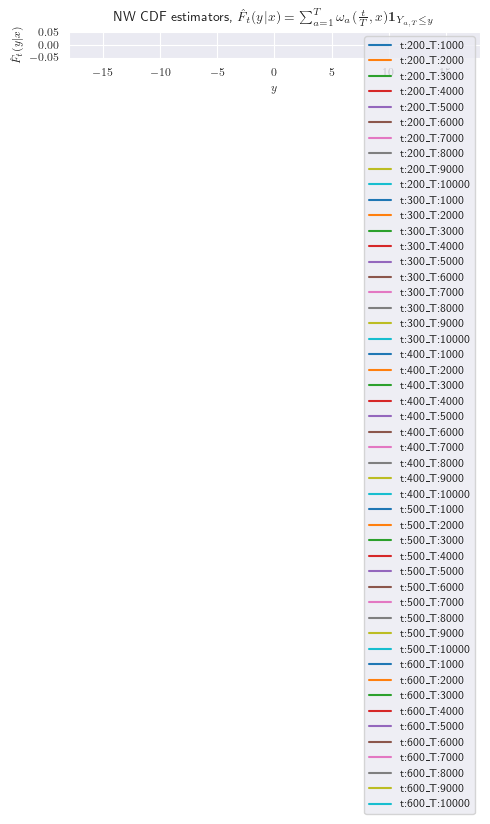

In [68]:


x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(1): #range(n_replications): #range(n_replications):
   # sns.lineplot(x=X_tvar_2_replications[replication], y=replicated_NW_cdfs_100[str(replication)])
   # plt.ecdf(X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # sns.ecdfplot(data=None, x=X_tvar_2_replications[replication], weights=weights_100[str(replication)][99])
   # data = X_tvar_2_replications[replication] * weights_100[str(replication)][99]
   # plt.plot(np.sort(a), np.linspace(0., 1., len(a), endpoint=False), c='g',lw=2)
   # plt.plot(np.sort(data), np.arange(1, len(data)+1) / len(data))
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            plt.xlabel(r'$y$')
            plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xticks(np.arange(0, T+1, 200, dtype=int))
            plt.xlim(-18, 18)
            plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            plt.legend()
            plt.tight_layout()
            plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [69]:
x_rep = {} 
y_rep = {} 

wasserstein_distances = {}

for t in times_t:
    for T in times_T:
        x_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        y_rep[f"t:{t}_T:{str(T)}"] = np.zeros((n_replications, T))
        wasserstein_distances[f"t:{t}_T:{T}"] = {}

for replication in range(n_replications):
    for t in times_t:
        for T in times_T:
            y, x = eval_univariate(
                X_tvar_2_replications[f"T:{T}"][replication], gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)]
                # gaussian_weights_tensor[f"t:{t}_T:{str(T)}"][str(replication)] * X_tvar_2_replications[f"T:{T}"][replication]
            )
            x_rep[f"t:{t}_T:{str(T)}"][replication] = x
            y_rep[f"t:{t}_T:{str(T)}"][replication] = y
            distance = wasserstein_distance(y, scp.stats.norm.cdf(X_tvar_2_replications[f"T:{T}"][replication]))
            wasserstein_distances[f"t:{t}_T:{T}"][str(replication)] = distance
   
   
            # plt.plot(x, y, label=f"t:{t}_T:{T}")# _replication:{replication}")
            # plt.xlabel(r'$y$')
            # plt.ylabel(r'$\hat{F}_t(y|x)$')
            # plt.xlim(-18, 18)
            # plt.title(r'NW CDF estimators, $\hat{F}_{t}(y|{x})=\sum_{a=1}^T\omega_{a}(\frac{t}{T},{x})\mathbf{1}_{Y_{a,T}\leq y}$')
            # plt.legend()
            # plt.tight_layout()
            # plt.savefig(path_fig+"nadar_watson_weights_", dpi=150)

In [70]:
# print(x_rep.shape, y_rep.shape)
# plt.plot(x_rep.mean(axis=0), y_rep.mean(axis=0), label="mean", linewidth=4)
# X_tvar_2_50_norm = scp.stats.norm.cdf(X_tvar_2_50)
# sns.lineplot(x=X_tvar_2_50, y=X_tvar_2_50_norm, label=f"{T}", linewidth=2 )
# eval_univariate(X_tvar_2_100_norm)
# plt.legend()
# plt.show()

#print("Mean values of y_rep across replications:", y_rep.mean(axis=0))
#y_rep.mean(axis=0).shape
# print("Wasserstein distance for each replication: ", wasserstein_distances)

In [71]:
# x_rep.keys(), x_rep['t:1000_T:10000'].shape

In [72]:
# plt.rcParams["figure.figsize"] = (10,3)
# for t in times_t:
#     for T in times_T:
#         plt.plot(x_rep[f"t:{t}_T:{T}"].mean(axis=0), y_rep[f"t:{t}_T:{T}"].mean(axis=0), label=f"Mean NW t:{t}_T:{T}", linewidth=1)
#         sns.lineplot(x=X_tvar_2[f"t:{t}_T:{T}"], y=empirical_cds[f"t:{t}_T:{T}"], label=f"Empirical CDF t:{t}_T:{T}", linewidth=1)
#         plt.xlim(-18, 18)
#         plt.legend()
#         plt.tight_layout()
#         plt.savefig(path_fig+"mean_nadara_Watson", dpi=150)

In [73]:
# wasserstein_distances['t:1000_T:5000']

In [74]:
wass_distances_all_replications = {}

for t in times_t:
    for T in times_T:
        wass_distances_all_replications[f"t:{t}_T:{T}"] = []

for t in times_t:
    for T in times_T:       
        for replications in range(n_replications):
            wass_distances_all_replications[f"t:{t}_T:{T}"].append(wasserstein_distances[f"t:{t}_T:{T}"][str(replication)])
        

In [75]:
# plt.rcParams["figure.figsize"] = (10,3)
# for t in times_t:
#     for T in times_T:
#         plt.plot(wass_distances_all_replications[f"t:{t}_T:{T}"])

In [76]:
plt.rcParams["figure.figsize"] = (10,3)
wass_distances_empirical_meanNW = {}
for t in times_t:
    for T in times_T:
        wass_distances_empirical_meanNW[f"t:{t}_T:{T}"] = wasserstein_distance(
            empirical_cds[f"t:{t}_T:{T}"], y_rep[f"t:{t}_T:{T}"].mean(axis=0)
        )

In [77]:
wass_distances_empirical_meanNW

{'t:200_T:1000': nan,
 't:200_T:2000': nan,
 't:200_T:3000': nan,
 't:200_T:4000': nan,
 't:200_T:5000': nan,
 't:200_T:6000': nan,
 't:200_T:7000': nan,
 't:200_T:8000': nan,
 't:200_T:9000': nan,
 't:200_T:10000': nan,
 't:300_T:1000': nan,
 't:300_T:2000': nan,
 't:300_T:3000': nan,
 't:300_T:4000': nan,
 't:300_T:5000': nan,
 't:300_T:6000': nan,
 't:300_T:7000': nan,
 't:300_T:8000': nan,
 't:300_T:9000': nan,
 't:300_T:10000': nan,
 't:400_T:1000': nan,
 't:400_T:2000': nan,
 't:400_T:3000': nan,
 't:400_T:4000': nan,
 't:400_T:5000': nan,
 't:400_T:6000': nan,
 't:400_T:7000': nan,
 't:400_T:8000': nan,
 't:400_T:9000': nan,
 't:400_T:10000': nan,
 't:500_T:1000': nan,
 't:500_T:2000': nan,
 't:500_T:3000': nan,
 't:500_T:4000': nan,
 't:500_T:5000': nan,
 't:500_T:6000': nan,
 't:500_T:7000': nan,
 't:500_T:8000': nan,
 't:500_T:9000': nan,
 't:500_T:10000': nan,
 't:600_T:1000': nan,
 't:600_T:2000': nan,
 't:600_T:3000': nan,
 't:600_T:4000': nan,
 't:600_T:5000': nan,
 't:60

In [78]:
plt.rcParams["figure.figsize"] = (10,3)
wass_times_t = {}

for t in times_t:
    wass_times_t[f"t:{t}"] = []

for t in times_t:
    for T in times_T:
        wass_times_t[f"t:{t}"].append(wass_distances_empirical_meanNW[f"t:{t}_T:{T}"])

In [79]:
import pickle 
with open(f"wass_distance{times_t}{times_T}_{n_replications}.pkl", 'wb') as f:
    pickle.dump(wass_times_t, f)

# wass_times_t

\begin{align*}
    \sup_{\boldsymbol{x}\in \mathcal{X}, \frac{t}{T}\in I_h} E\big[W_1\big(\hat{\pi}_t(\cdot|\boldsymbol{x}), \pi_t^\star(\cdot|\boldsymbol{x})\big)\big]
    &= O_P\Big(\frac{1}{T^{\frac{1}{2}} h^{d + 1 - \frac{1}{p}(1-\nu)}} + \frac{1}{T^\nu h^{d + \nu - 1}} + h\Big).
\end{align*}

0.001
0.019407407407407408
0.037814814814814815
0.05622222222222222
0.07462962962962963
0.09303703703703703
0.11144444444444444
0.12985185185185186
0.14825925925925926
0.16666666666666666


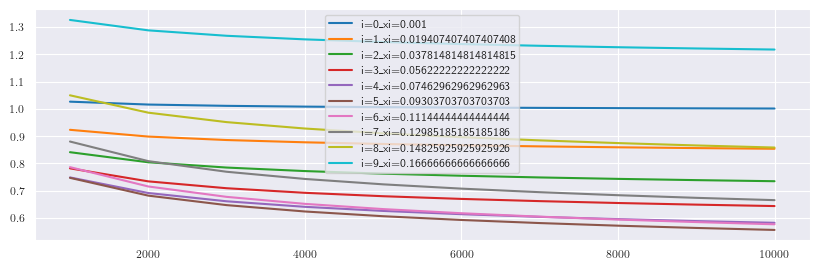

In [80]:
for i, xi in zip(range(10), np.linspace(1e-3, 1./(2*(d+1)), 10)):
    
    bandwidths = np.array(times_T)**(-xi)

    bounds = 1./(np.sqrt(np.array(times_T)) * bandwidths**(d+1)) + 1./(np.array(times_T) * bandwidths**(d)) + bandwidths
    plt.plot(times_T, bounds, label=f"i={i}_xi={xi}")
    print(xi)
    plt.legend()

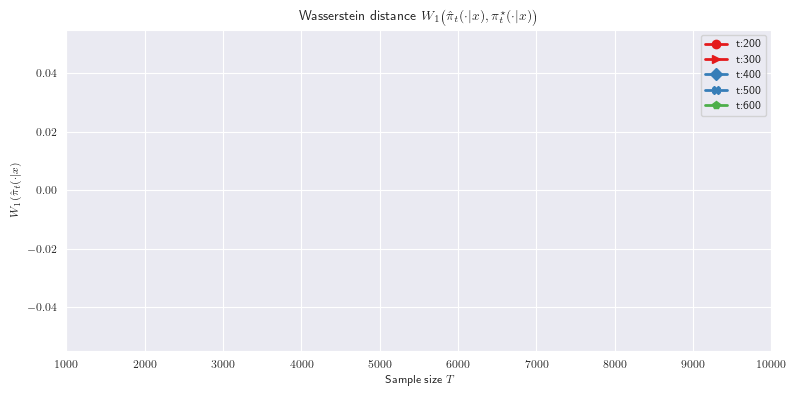

In [81]:

plt.rcParams["figure.figsize"] = (8,4)
colors = plt.cm.Set1(np.linspace(0, .5, 8))
markers = ['o', '>', 'D', 'X', "p"]

for i, t in zip(range(len(times_t)), times_t):
    plt.plot(times_T, wass_times_t[f"t:{t}"], label=f"t:{t}", color=colors[i], marker=markers[i], markersize=6, lw=2)
    plt.xlim(np.array(times_T).min(), np.array(times_T).max())
    plt.title(r'Wasserstein distance $W_1\big(\hat{\pi}_t(\cdot|{x}), \pi_t^\star(\cdot|{x})\big)$')
    plt.xlabel(r'Sample size ${T}$ ')
    plt.ylabel(r'$W_1(\hat{\pi}_t(\cdot|{x})$')
    plt.legend()
    plt.tight_layout()
    plt.savefig(path_fig+f"wass_distance{times_t}{times_T}_{n_replications}_kernel_{kernel}", dpi=150)

In [82]:
for  t in times_t:
    print(type(wass_times_t[f"t:{t}"]))

<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
<class 'list'>
